<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/opencv-projects-and-guide/ocr-with-opencv-and-tesseract/08_improving_ocr_with_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Improving OCR with Basic Image Processing

In [ ]:
%%shell

sudo apt install tesseract-ocr
pip install tesseract
pip install pytesseract
pip install Pillow==9.0.0

Just restart the colab environment.

In [1]:
import cv2
import pytesseract
import csv
import numpy as np


from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

%matplotlib inline

In [2]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

Let's download images.

In [ ]:
%%shell

wget https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/opencv-projects-and-guide/ocr-with-opencv-and-tesseract/images/text-orient-1.png
wget https://github.com/rahiakela/computer-vision-research-and-practice/raw/main/opencv-projects-and-guide/ocr-with-opencv-and-tesseract/images/text-orient-1.png

In [ ]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [15]:
def img_display(im_data=None, img_path=None):
    dpi = 80
    if img_path is not None:
      im_data = plt.imread(img_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [3]:
def psm_options(img_path, options=None):
  image = cv2.imread(img_path)

  image_bgr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # determine the text orientation
  results = pytesseract.image_to_string(image_bgr, config=options)
  return results

##Problem

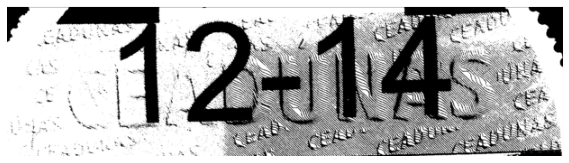

In [11]:
img_display("aRh8C.png")

In [4]:
results = psm_options("aRh8C.png")
results

' \n\x0c'

In [5]:
results = psm_options("aRh8C.png", options="--psm 8")
results

' T2eti@ce\n\x0c'

In [6]:
results = psm_options("aRh8C.png", options="--psm 7")
results

'\x0c'

Unfortunately, Tesseract, regardless of PSM mode, is utterly failing to OCR this image as is, returning either nothing at all or total gibberish.

Do we mark this image as “impossible to OCR”?

Not so fast — all we need is a bit of image processing.

##Image Processing Pipeline for OCR

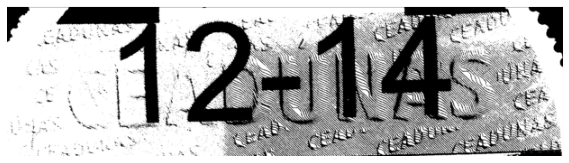

In [17]:
img_display(img_path="aRh8C.png")

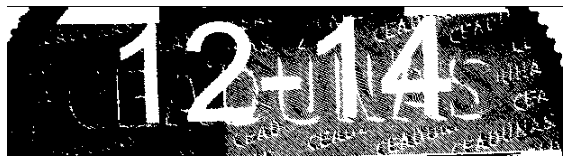

In [16]:
# load the input image and convert it to grayscale
image = cv2.imread("aRh8C.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# threshold the image using Otsu's thresholding method
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
img_display(thresh)